# Real Time Test: Combining both the Siamese and the Classification Models

#### General Steps to Follow

1. Importing Packages.
1. Classification Model
1. Siamese Model
1. Preprocessing Input Image
1. Getting Similar Images from Database
1. Real Time Test with input image from a path

### ----------------------------------------------------------------------------------------------------------------------------------------------------------

## 1) Importing Packages

In [1]:
from ultralytics import YOLO
import cv2
from ultralytics.yolo.utils.plotting import Annotator
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Layer

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

2023-11-30 15:28:28.046482: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 15:28:28.046529: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 15:28:28.046577: E tensorflow/compile

### ----------------------------------------------------------------------------------------------------------------------------------------------------------

## 2) Classification Model

In [3]:
clas_model_path = "../data/best.pt"
class_model = YOLO(clas_model_path)

##### Results from the YOLOY classification model

In [4]:
def predict_image(image):
    results = model.predict(image,show_conf=True)
    return results

##### In case the input image contains multiple types of clothes. Each type will be cropped and treated as a single image.

In [5]:
def Crop_types(results,image,model):
    types = {
        "shirts" : [],
        "jeans"  : [],
        "jackets": [],
        "shoes"  : []}
    for r in results:    
            annotator = Annotator(image)
            boxes = r.boxes
            for box in boxes:
                if(box.conf > 0.6):
                    b = box.xyxy[0] 
                    c = box.cls
                    top, left, bottom, right = map(int, b)
                    cropped_image = image[left:right, top:bottom]
                    types[model.names[int(c)]].append(cropped_image)
    return types

### ----------------------------------------------------------------------------------------------------------------------------------------------------------

## 3) Siamese Model

#### The distance layer

In [6]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, anchor, validation):
        return tf.abs(anchor - validation)

In [7]:
siamese_model = tf.keras.models.load_model('../data/siamese_model.h5', 
                                   custom_objects={'L1Dist': L1Dist})

2023-11-30 15:28:40.732936: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### ----------------------------------------------------------------------------------------------------------------------------------------------------------

## 4) Preprocessing Input Image

In [8]:
image_size = (105,105)

In [9]:
def preprocessingImage(image):
    image = cv2.resize(image,image_size) #Resizing data into (105,105,3)
    image = image/255.0                  #Normalizing the image
    image = image.reshape((1,105,105,3))
    return image

### ----------------------------------------------------------------------------------------------------------------------------------------------------------

## 5) Getting Similar Images from Database

##### Getting the similar images to only one input image from the database

In [94]:
def getSimilarImages(image,type):
    image_path = "../database/images/"   #Path of similar images
    image_info = "../database/info/"    #Info of similar images(store/price)
    anc_image = preprocessingImage(image)
    similar_images = []                #contains similar images and their info
    
    for img in os.listdir(image_path + type):
        ver_image = cv2.imread(image_path + type + "/" + img)
        ver_image_edited = preprocessingImage(ver_image)
        y_hat = siamese_model.predict([anc_image,ver_image_edited])
        if y_hat[0,0] >= 0.7:
            file_name_without_extension = os.path.splitext(img)[0]
            file_path = image_info + type + "/" + file_name_without_extension + ".txt"
            with open(file_path, 'r') as file:
                # Read the entire content of the file into a string
                file_content = file.read()
            similar_images.append([ver_image,file_content])
    return similar_images

##### Getting the similar images to multiple input images from the database

In [30]:
def multiTypeSimilarImages(types):
    similar_images_total = []                 #All similar images for each type
    for type in types:
        for i in range(0,len(types[type])):
            image = types[type][i]
            similar_images_total.append(getSimilarImages(image,type))
    return similar_images_total

In [126]:
image = cv2.imread("test.jpg")                   #test image
similar_images = getSimilarImages(image,"jeans")

1/1 [==============================] - 0s 18ms/step


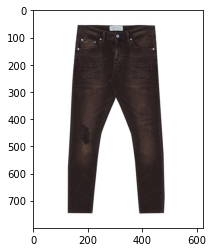

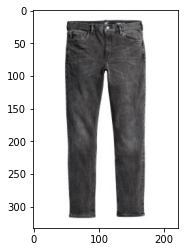

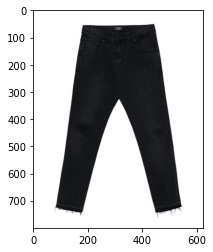

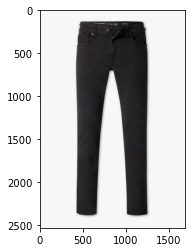

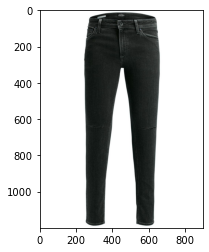

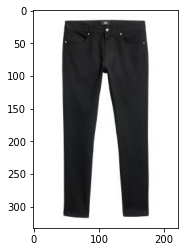

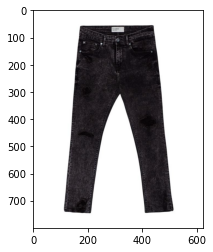

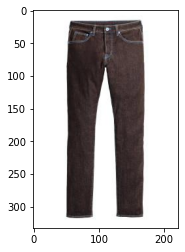

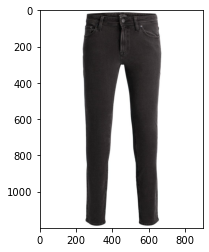

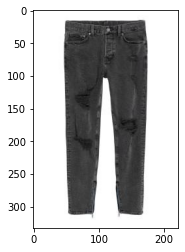

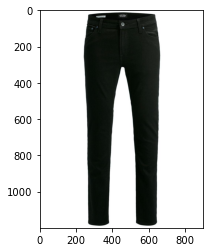

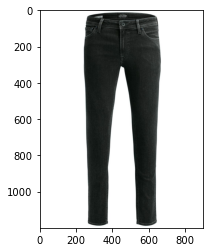

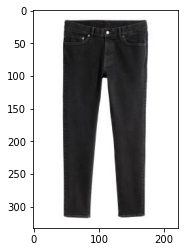

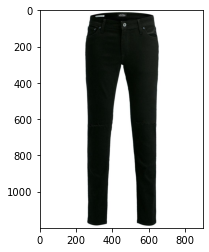

In [127]:
for x in similar_images:
    plt.imshow(x[0])
    plt.show()

### ----------------------------------------------------------------------------------------------------------------------------------------------------------

## 6) Real Time Test with input image from a path

In [128]:
def getOutput(image_path):
    input_image = cv2.imread(image_path)
    yolo_results = class_model.predict(input_image,show_conf=True)
    types = Crop_types(yolo_results,input_image,class_model)
    similar_images = multiTypeSimilarImages(types)
    return similar_images

In [129]:
image_path = "../database/images/jeans/1.jpg"
similar_images = getOutput(image_path)


0: 640x448 1 jeans, 69.3ms
Speed: 14.3ms preprocess, 69.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


1/1 [==============================] - 0s 19ms/step


#### Saving the similar images into "saved similar images folder"

In [130]:
for type in similar_images:
    cnt = 0
    for x in type:
        cnt += 1
        cv2.imwrite("../saved similar images/" + str(cnt) + ".jpg", x[0])